# Exploratory Data Analysis: Food Crises

**Tasks**
* Conduct non-spatial temporal analysis
* Conduct spatial analysis
* Conduct temporal analysis
* Pre-process data according to analysis
* Run time: < 10 minutes




In [78]:
# env packages: standard env, +pysal, + jupyter, + matplotlib
#### import libraries ####
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.explore import esda
from pysal.lib import weights
from statistics import mean
import timeit
os.getcwd()

start = timeit.default_timer()

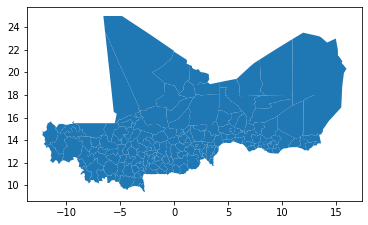

set()
set()


In [79]:
# Get data from pre-processing file
%run EDA_preprocessing.ipynb

**Data manipulations**
* Transpose predictor variable (FEWs IPC classification) into matrix to make data manipulation easier

In [80]:
#### ** Data manipulations ** ####
y = df.groupby(['country', 'admin_name', 'year'])['fews_ipc'].mean().reset_index()
m = df.groupby(['country', 'admin_name', 'month'])['fews_ipc'].mean().reset_index()
ym = df.groupby(['country', 'admin_name', 'year_month'])['fews_ipc'].mean().reset_index()
# transpose matrix & row means
year_m = y.pivot(index='admin_name', columns='year', values='fews_ipc')
month_m = m.pivot(index='admin_name', columns='month', values='fews_ipc')
yearmonth_m = ym.pivot(index='admin_name', columns='year_month', values='fews_ipc')



## 3. Exploratory Analysis

**Non spatial-temporal analysis**
* Check predictive feature
* Examine covariate correlations

<AxesSubplot:>

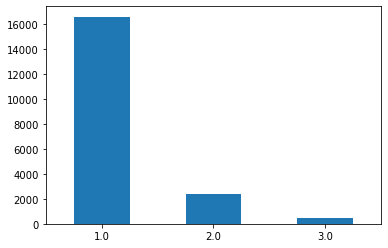

In [81]:
#### NON SPATIAL-TEMPORAL ANALYSIS ####

# Look at data
# print(df.describe())

# Examine predictive feature (few_ipc & flooding) - barplots
df['fews_ipc'].value_counts().plot.bar(rot=0)

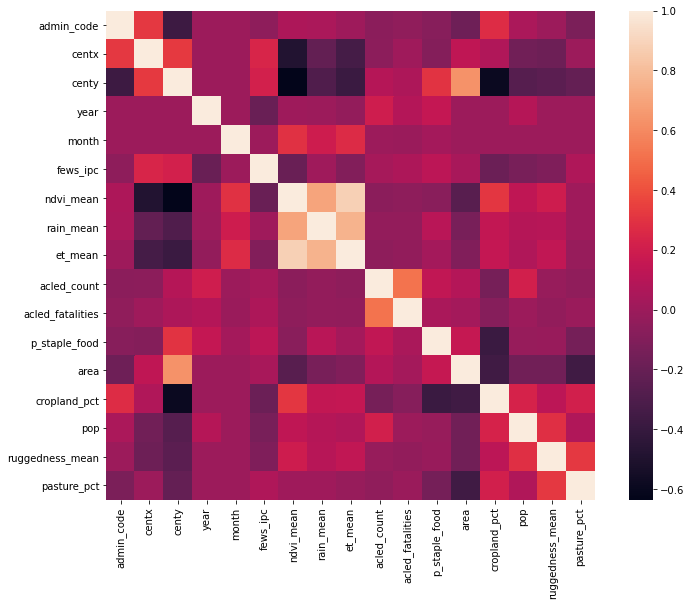

In [82]:
# Examine correlation between features and target variable - corplots
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

**Spatial Analysis**

* Examine spatial distribution over annual averages & monthly averages
* Check spatial dependency with Moran's Global I and Moran's Local I Clusters
* Does it need a space lag or not?


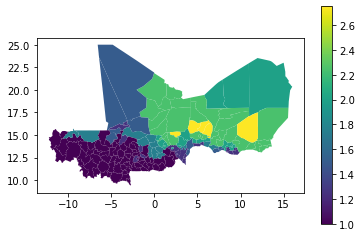

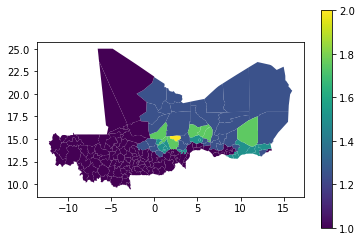

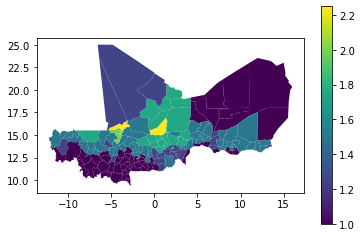

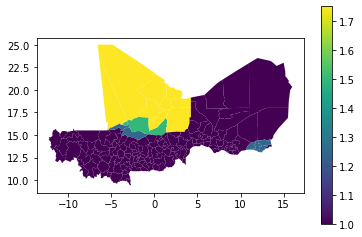

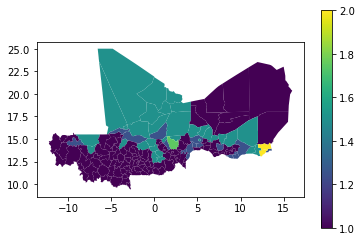

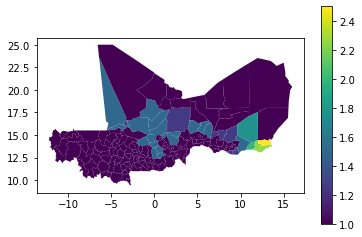

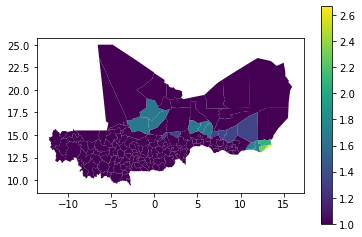

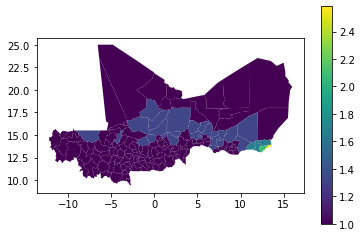

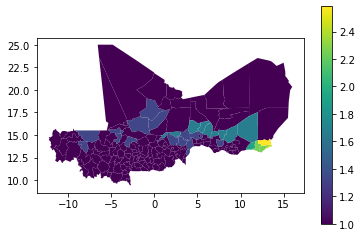

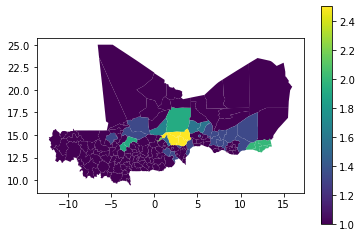

In [83]:
#### SPATIAL ANALYSIS ####
# Visuals: https://stackoverflow.com/questions/50435713/custom-legend-labels-geopandas-plot

# Spatial distribution over annual average
years = list(year_m.columns)
for i in years:
    t = y.groupby('year').get_group(i)
    dist = pd.merge(shape, t, on='admin_name')
    dist.plot(column='fews_ipc', cmap='viridis', legend=True)


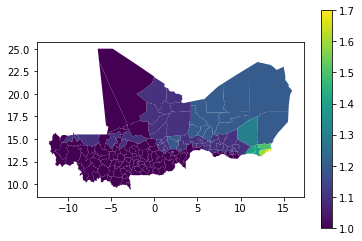

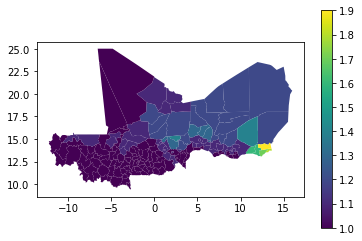

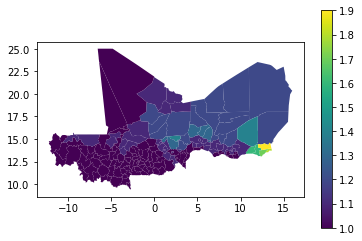

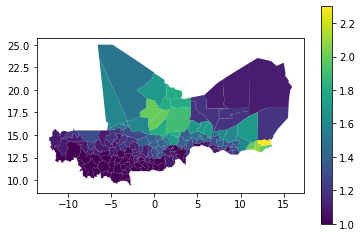

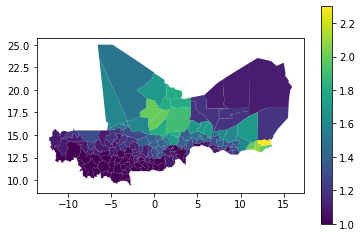

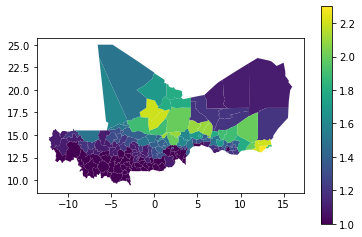

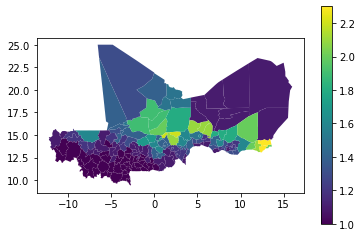

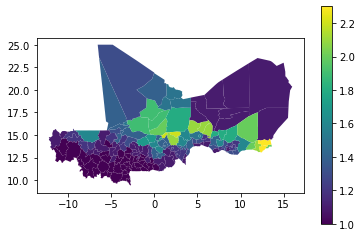

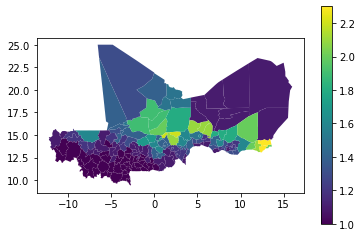

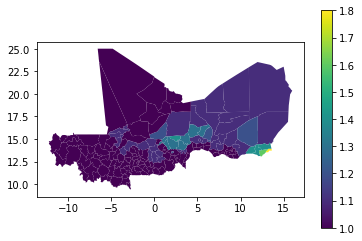

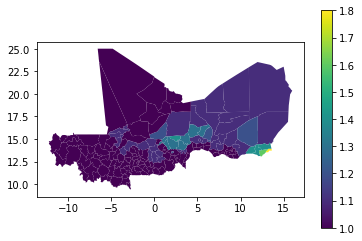

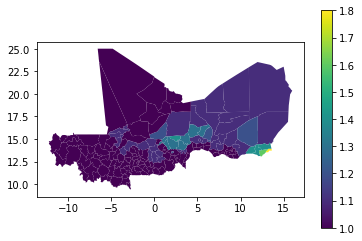

In [84]:
# Spatial distribution over monthly average
months = list(month_m.columns)
for i in months:
    t = m.groupby('month').get_group(i)
    dist = pd.merge(shape, t, on='admin_name')
    dist.plot(column='fews_ipc', cmap='viridis', legend=True)


In [85]:
# SOURCE: https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-autocorrelation

# Check Spatial Dependency
# --> Moran's Global I
w = weights.KNN.from_dataframe(shape, k=8) # Generate W from the GeoDataFrame
w.transform = 'R' # Row-standardization

# compute spatial lag of a given variable
lag = weights.spatial_lag.lag_spatial(w, year_m.mean(axis=1))
moran = esda.moran.Moran(year_m.mean(axis=1), w)
print('Morans I value: ', moran.I) # value of Moran’s I
print('P-value based on permutations: ', moran.p_sim) # (if permutations>0) p-value based on permutations (one-tailed) null: spatial randomness alternative: the observed I is extreme if it is either extremely greater or extremely lower than the values obtained based on permutations

Morans I value:  0.02554420144770816
P-value based on permutations:  0.175


Given a confidence level of 95%, the global Moran’s I test had a p-value > -0.05225,
thus failing to reject the null hypothesis and suggesting that spatial autocorrelation in this dataset
is due to chance.

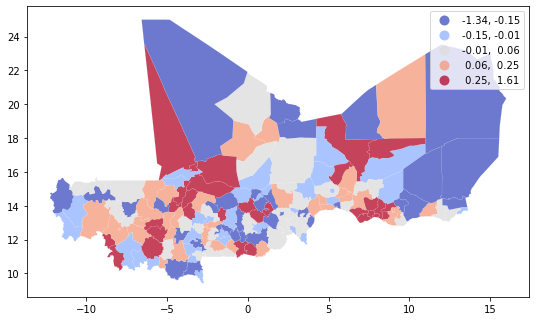

In [86]:
# --> Moran's Local I Clusters
local = esda.moran.Moran_Local(year_m.mean(axis=1), w)
# ax = sns.kdeplot(local.Is)
# sns.rugplot(local.Is, ax=ax)

f, ax = plt.subplots(1, figsize=(9,9))
shape['Is'] = local.Is
shape.plot(column='Is', cmap='coolwarm', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);

**Temporal Analysis**

* Examine temporal distribution over annual averages & monthly averages
* Check heatmap by admin food crises means to examin effects
* Check temporal dependencies: ACF, PACF


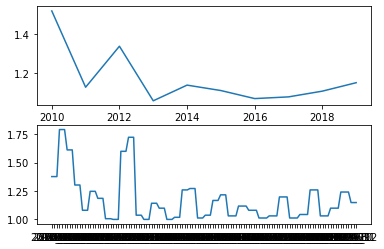

In [87]:
#### TEMPORAL ANALYSIS ####
# Look at the mean few_ipc across country over time (in years)
plt.figure()
plt.subplot(211)
q = year_m.mean(axis=0)
plt.plot(years, q)

# Look at the mean few_ipc across country over time (in months)
plt.subplot(212)
yearmonth = list(yearmonth_m.columns)
p = yearmonth_m.mean(axis=0)
plt.plot(yearmonth, p)
plt.show()

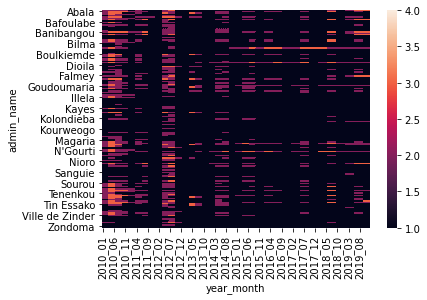

In [88]:
# Order heat map by admin food security means to examine effects
sns.heatmap(yearmonth_m, vmax=4);

C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
C:\Users\offne\.conda\envs\diss\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


<AxesSubplot:>

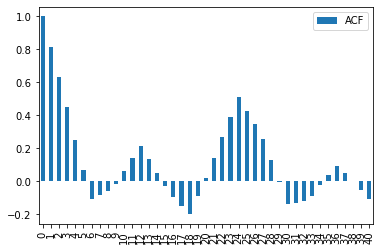

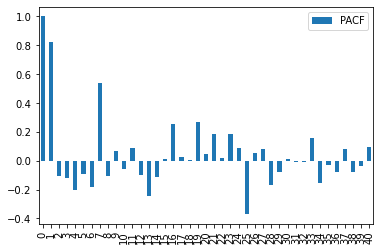

In [89]:
from statsmodels.tsa.stattools import acf, pacf

# Check Temporal Dependency
# --> ACF
acf =  acf(yearmonth_m.mean(axis=0))
acf1 = pd.DataFrame(acf)
acf1.columns = ['ACF']
acf1.plot(kind='bar')
# --> PACF
pacf =  pacf(yearmonth_m.mean(axis=0))
pacf1 = pd.DataFrame(pacf)
pacf1.columns = ['PACF']
pacf1.plot(kind='bar')

## 4. Model Pre-processing

**Time Lags** (depends on temporal analysis)
* Time lag of 6 for general time trends
* Time lag of 12 for seasonal time trends

In [90]:
# Group by admin
groups = df.groupby('admin_name')

# i.e. Add lag of 6 for general time trends
timelag = {}
for admin, group in groups:
    group['timelag'] = group['fews_ipc'].shift(6)
    timelag[admin] = tuple(group['timelag'])

col = set(df['year_month'].tolist())
timelag1 = pd.DataFrame.from_dict(timelag)
timelag1 = timelag1.T
timelag1.columns = set(df['year_month'].tolist())
timelag1 = timelag1.stack(dropna = False).reset_index()
timelag1.columns = ['admin_name','year_month','timelag1']

In [91]:
# i.e. Add lag of 12 for seasonal time trends
timelag = {}
for admin, group in groups:
    group['timelag'] = group['fews_ipc'].shift(12)
    timelag[admin] = tuple(group['timelag'])

col = set(df['year_month'].tolist())
timelag2 = pd.DataFrame.from_dict(timelag)
timelag2 = timelag2.T
timelag2.columns = set(df['year_month'].tolist())
timelag2 = timelag2.stack(dropna = False).reset_index()
timelag2.columns = ['admin_name','year_month','timelag2']


**Space lag** (depends on spatial analysis)
* A. Create spatial weight matrix (Queen contiguity because we consider observations that share a vertex to be
neighbors)
* B. Extract list of neighbors for each admin_name
* C. For each list of neighbors (nest_list), at every time interval (df_m_matrix), take the neighbors average of
fews_ipc
* D. Store nested averages in final data frame



In [92]:
# !! Make sure not to include admin of concern in this !!
s = shape.sort_values('admin_name')
s = s.reset_index()
s = s.drop(['index'], axis=1)

In [93]:
# A. Spatial weight matrix
# Queen contiguity matrix (we consider observations that share a vertex to be neighbors)
wq = weights.contiguity.Queen.from_dataframe(s)
n = wq.neighbors
w = wq.weights
print(n)

{0: [16, 129, 49, 9, 44, 143], 1: [65, 34, 129, 134, 23, 73], 2: [139, 76], 3: [65, 131, 23, 22, 135, 24, 138], 4: [98, 53, 140, 61, 95], 5: [51, 100, 60], 6: [65, 63, 135], 7: [137, 114, 142], 8: [112, 38, 72, 75, 156, 77], 9: [0, 129, 64, 25, 44], 10: [120, 148, 103], 11: [49, 91, 27, 78], 12: [121, 117], 13: [], 14: [123, 108, 85, 79], 15: [17, 146, 83, 102, 43, 46], 16: [0, 49, 114], 17: [146, 83, 15], 18: [137], 19: [], 20: [40, 26, 123, 85], 21: [32, 161, 67, 159], 22: [98, 3, 131, 36, 23], 23: [65, 34, 1, 3, 36, 22], 24: [3, 135, 104, 138, 63], 25: [64, 97, 44, 9], 26: [20, 119, 40, 89, 123], 27: [48, 91, 11, 45, 78], 28: [105, 39], 29: [80, 71, 40, 154, 125], 30: [148], 31: [], 32: [67, 21, 117, 88, 120, 159], 33: [145, 51, 139, 76, 60], 34: [64, 1, 97, 36, 23, 73, 94], 35: [], 36: [98, 34, 22, 23, 61, 94], 37: [96, 130, 131, 101, 58, 47], 38: [112, 8, 108, 77, 79], 39: [105, 99, 28], 40: [29, 20, 85, 71, 89, 26, 125], 41: [45, 52, 141], 42: [145, 60, 110, 57], 43: [146, 102, 1

C:\Users\offne\.conda\envs\diss\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 29 disconnected components.
 There are 26 islands with ids: 13, 19, 31, 35, 50, 62, 66, 74, 82, 84, 86, 90, 92, 106, 113, 116, 118, 124, 126, 127, 128, 132, 144, 153, 155, 160.
  warnings.warn(message)


In [94]:
# B. Extract list of neighbors for each admin_name
from itertools import chain

neighbors = []
for i in n:
    dist = s['admin_name'][i]
    l = []
    for j in n[i]:
        name = s['admin_name'][j]
        l.append(name)
    # neighbors.add(dist, l)
    neighbors.append({dist: l})

In [95]:
# C. For each list of neighbors (nest_list), at every time interval (df_m_matrix), take the neighbors average of fews_ipc

res = []
for item in range(len(neighbors)):
    l = list(neighbors[item].values())
    l = list(chain.from_iterable(l))
    d = list(neighbors[item].keys())
    d = d[0]
    timeseries = [d]
    for c, col in yearmonth_m.iteritems(): # iterate column numbers
        num = []
        for neigh in l:
            for r, row in yearmonth_m.iterrows():
                if r == neigh:
                    v = yearmonth_m.loc[r, c]
                    num.append(v)
        if not num:
            av = 'NA'
        else:
            av = mean(num)
        timeseries.append(av)
    res.append(timeseries)


In [96]:
# D. Store nested averages in final data frame
c = list(yearmonth_m.columns)
c.insert(0, 'admin_name')
spacelag = pd.DataFrame(res)
spacelag.columns = c
spacelag = spacelag.set_index('admin_name')
spacelag = pd.melt(spacelag) #merge on index


**Merge space & time lags**

In [97]:
# Merge timelag1, timelag2 and spacelag on index
df['spacelag'] = spacelag['value']
df['timelag1'] = timelag1['timelag1']
df['timelag2'] = timelag2['timelag2']
df = df[['country', 'admin_code', 'admin_name', 'centx', 'centy', 'year_month', 'year', 'month', 'fews_ipc', 'ndvi_mean',
         'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct',
         'pop', 'ruggedness_mean', 'pasture_pct', 'spacelag', 'timelag1', 'timelag2', 'geometry']]


Running Time:  432.2533401999999 seconds


**Download data**

In [98]:
df.to_csv('Data/FS_data.csv', index = False)

stop = timeit.default_timer()
print('Running Time: ', stop - start, 'seconds')